## Problem Statement

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

Data description:
* **city:** city this user signed up in
* **phone:** primary device for this user
* signup_date: date of account registration; in the form ‘YYYYMMDD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
* **avg_dist:** the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* **avg_rating_of_driver:** the rider’s average rating of their drivers over all of their trips
* **surge_pct:** the percent of trips taken with surge multiplier > 1
* **avg_surge:** The average surge multiplier over all of this user’s trips
* **trips_in_first_30_days:** the number of trips this user took in the first 30 days after signing up
* **ultimate_black_user:** TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise
* **weekday_pct:** the percent of the user’s trips occurring during a weekday

We consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

Questions I am seeking to answer:

* Help Ultimate determine whether or not a user will be active in their 6th month on the system
* How might Ultimate leverage the insights gained from the model to improve its long term rider retention?

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO  
from IPython.display import Image 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

## Data Preparation

In [3]:
with open("ultimate_data_challenge.json", "r") as json_data:
    dict_data = json.load(json_data)

This is a list of users

In [4]:
df = pd.DataFrame(dict_data)
df.head(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

Check if I have to fix any strings. Looks like I do not.

In [7]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [8]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

Change the dates to datetime

In [9]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Add a feature with the time of last activity: 'days_since_last_trip' an d'days_since_signup'

In [11]:
df['days_since_last_trip'] = df.last_trip_date.max() - df['last_trip_date']
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

df['days_since_signup'] = df.last_trip_date.max() - df['signup_date']
df['days_since_signup'] = df['days_since_signup'].dt.days

df['days_last_trip_since_signup'] = df['last_trip_date'] - df['signup_date']
df['days_last_trip_since_signup'] = df['days_last_trip_since_signup'].dt.days

In [12]:
df['user_activity'] = df['days_since_last_trip'].apply(lambda x: 1 if x <= 30 else 0)

In [13]:
df = df.drop(['signup_date','last_trip_date'], axis = 1)

In [14]:
df["ultimate_black_user"] = df["ultimate_black_user"].astype(int)

In [15]:
df

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,days_since_last_trip,days_since_signup,days_last_trip_since_signup,user_activity
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,14,157,143,1
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,57,153,96,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,175,176,1,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,2,172,170,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,108,155,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,5.0,1.00,iPhone,0.0,0,100.0,5.63,4.2,26,157,131,1
49996,Astapor,1,NaN,1.00,iPhone,0.0,0,0.0,0.00,4.0,157,158,1,0
49997,Winterfell,0,5.0,1.00,Android,0.0,1,100.0,3.86,5.0,40,151,111,0
49998,Astapor,2,3.0,1.00,iPhone,0.0,0,100.0,4.58,3.5,167,168,1,0


## Exploratory Data Analysis

How many active users do we have?

In [17]:
print("%.1f%% of all users are active" % (df['user_activity'].mean()*100))

37.6% of all users are active


Compare the features for active and not active users using boxplots:

Active users appear to take more trips in the first 30 days

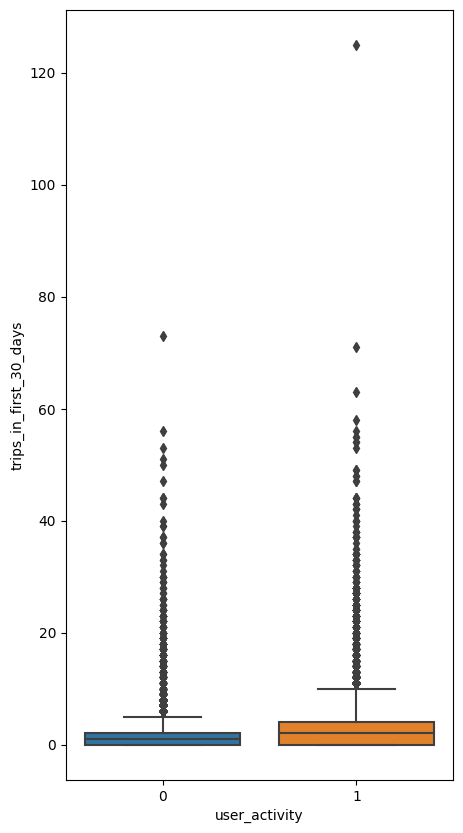

In [18]:
fig, ax = plt.subplots(1,1, figsize = (5,10))
sns.boxplot(data=df, x="user_activity", y="trips_in_first_30_days");

It appears that active users tend to give lower average rating of driver

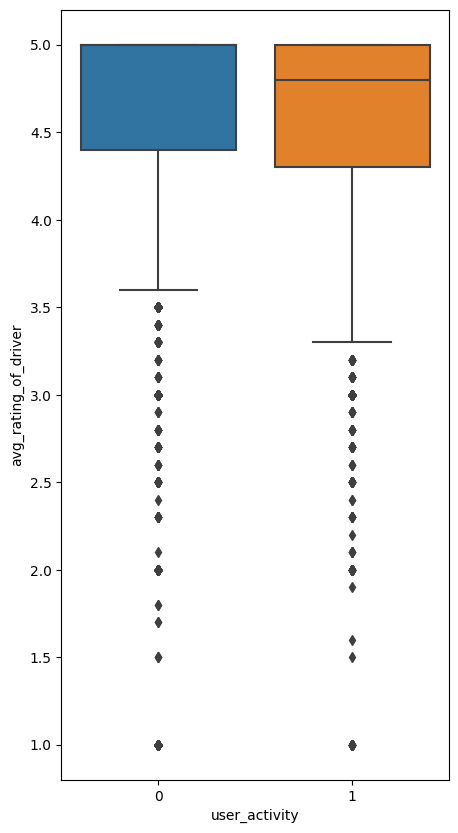

In [90]:
fig, ax = plt.subplots(1,1, figsize = (5,10))
sns.boxplot(data=df, x="user_activity", y="avg_rating_of_driver");

It appears active users tend to get lower average rating by driver

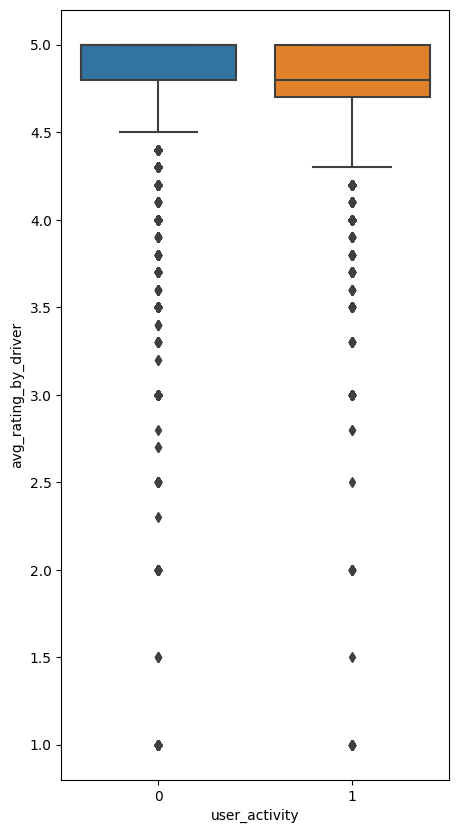

In [121]:
fig, ax = plt.subplots(1,1, figsize = (5,10))
sns.boxplot(data=df, x="user_activity", y="avg_rating_by_driver");

The average surge multiplier over all of this user’s trips appears to be the same for active and not active users

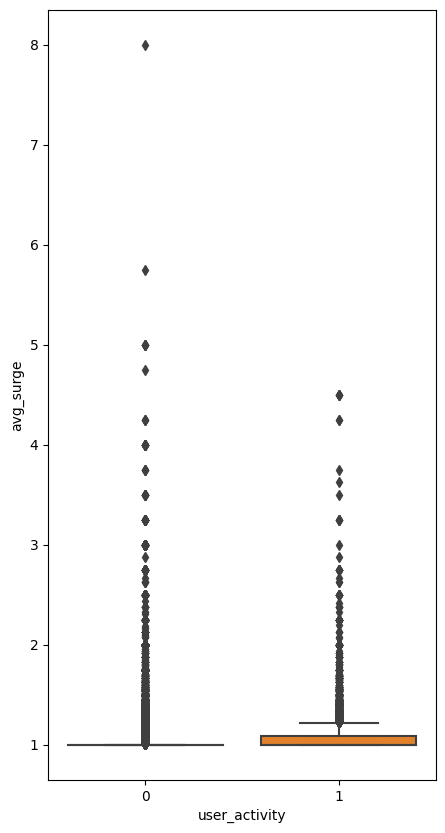

In [91]:
fig, ax = plt.subplots(1,1, figsize = (5,10))
sns.boxplot(data=df, x="user_activity", y="avg_surge");

the percent of trips taken with surge multiplier > 1 appears to be about the same for active and not active users

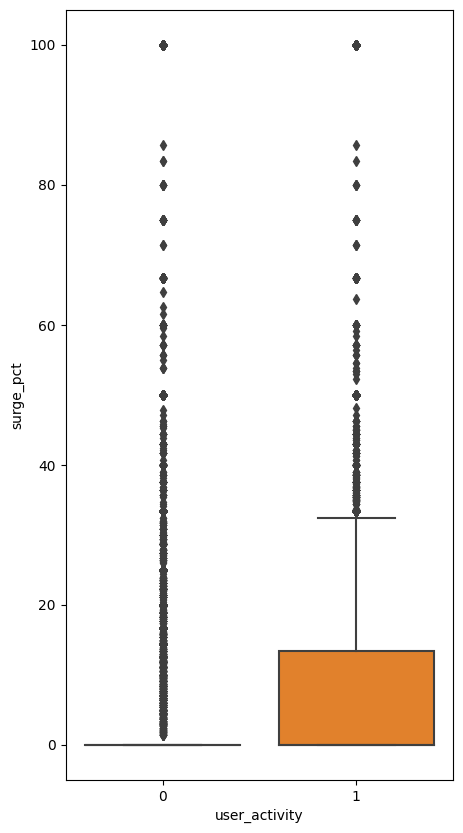

In [98]:
fig, ax = plt.subplots(1,1, figsize = (5,10))
sns.boxplot(data=df, x="user_activity", y="surge_pct");

 the percent of the user’s trips occurring during a weekday appears to be more concentrated around 50 - 80% for active users

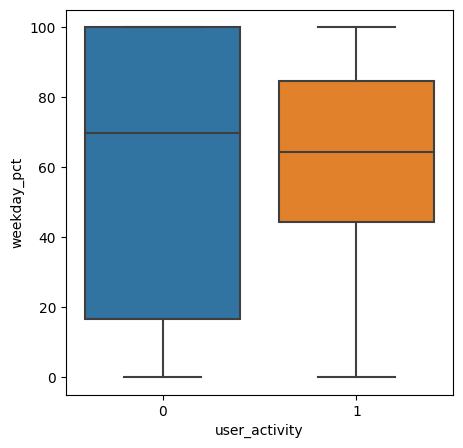

In [100]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
sns.boxplot(data=df, x="user_activity", y="weekday_pct");

The average distance in miles per trip taken in the first 30 days after signup tends to be higher for active users

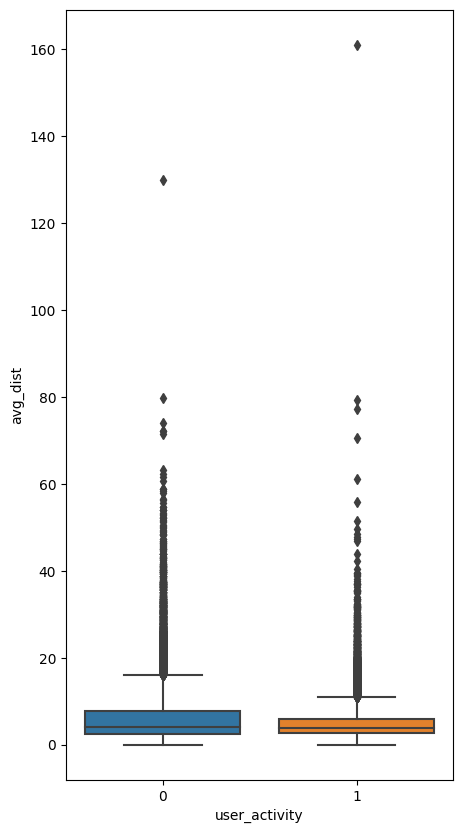

In [103]:
fig, ax = plt.subplots(1,1, figsize = (5,10))
sns.boxplot(data=df, x="user_activity", y="avg_dist");

active users tend to have longer days since signup, 

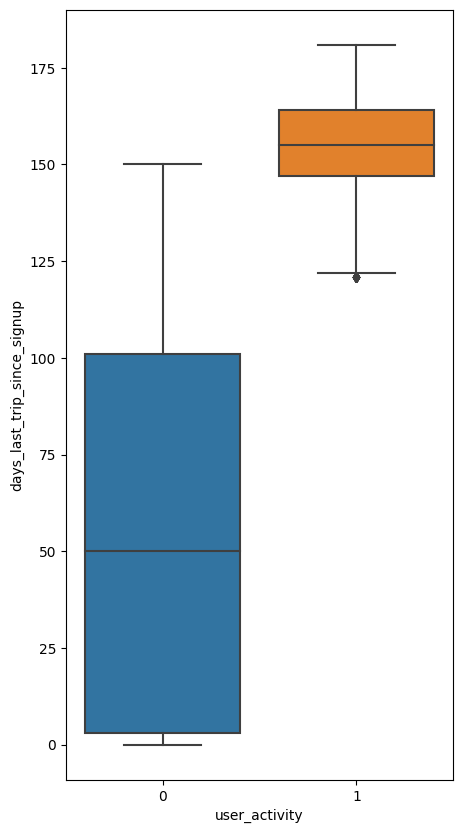

In [123]:
fig, ax = plt.subplots(1,1, figsize = (5,10))
sns.boxplot(data=df, x="user_activity", y="days_last_trip_since_signup");

does the percent of trips taken with surge multiplier > 1 change with location? It appears to have a wider distribution for King's Landing

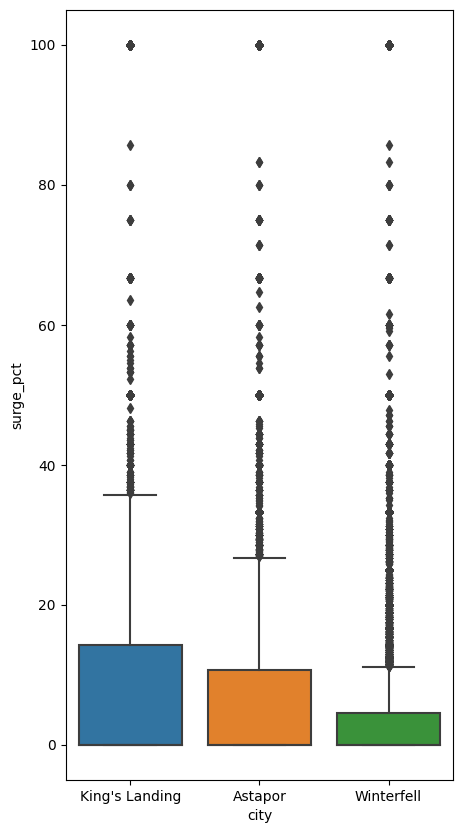

In [138]:
fig, ax = plt.subplots(1,1, figsize = (5,10))
sns.boxplot(data=df, x="city", y="surge_pct");

How many of the active users signed up in each of the cities?

In [87]:
cities = list(df.city.unique())
total_active_num = df['user_activity'].sum()

for city in cities:
    df_city = df[df['city'] == city]
    active_users_num = df_city['user_activity'].sum()
    print(city, (active_users_num/total_active_num)*100)

King's Landing 33.838544990427565
Astapor 22.48457774941502
Winterfell 43.67687726015742


Out of all active users, the highest percentage of them signed up in Winterfell

In [92]:
cities = list(df.city.unique())
total_active_num = df['user_activity'].sum()

for city in cities:
    df_city = df[df['city'] == city]
    active_users_num = df_city['user_activity'].sum()
    print(city, (active_users_num/50000)*100)

King's Landing 12.726
Astapor 8.456
Winterfell 16.426


Out of all users, whether active or not, the highest percentage are active and signed up in Winterfell

In [93]:
cities = list(df.city.unique())
total_active_num = df['user_activity'].sum()

for city in cities:
    df_city = df[df['city'] == city]
    users_in_city_num = len(df_city)
    active_users_num = df_city['user_activity'].sum()
    print(city, (active_users_num/users_in_city_num)*100)

King's Landing 62.81342546890425
Astapor 25.57154953429297
Winterfell 35.194549194377785


A larger portion of users in King's Landing are active users

In [96]:
phones = list(df.phone.unique())
total_active_num = df['user_activity'].sum()

for phone in phones:
    df_phone = df[df['phone'] == phone]
    active_users_num = df_phone['user_activity'].sum()
    print(phone, (active_users_num/total_active_num)*100)

iPhone 82.56222080408423
Android 16.73048287598383
None 0.0


Out of all active users, 83% use an iPhone

In [97]:
phones = list(df.phone.unique())
total_active_num = df['user_activity'].sum()

for phone in phones:
    df_phone = df[df['phone'] == phone]
    active_users_num = df_phone['user_activity'].sum()
    print(phone, (active_users_num/50000)*100)

iPhone 31.05
Android 6.292000000000001
None 0.0


Out of all users, whether active or not, the higher percentage are active and use an iPhone

In [95]:
phones = list(df.phone.unique())
total_active_num = df['user_activity'].sum()

for phone in phones:
    df_phone = df[df['phone'] == phone]
    users_in_phone_num = len(df_phone)
    active_users_num = df_phone['user_activity'].sum()
    print(phone, (active_users_num/users_in_phone_num)*100)

iPhone 44.89329709097218
Android 20.942617494341633
None nan


C:\Users\melis\AppData\Local\Temp\ipykernel_14100\2411499548.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  print(phone, (active_users_num/users_in_phone_num)*100)


A larger portion of users that use an iPhone are active users

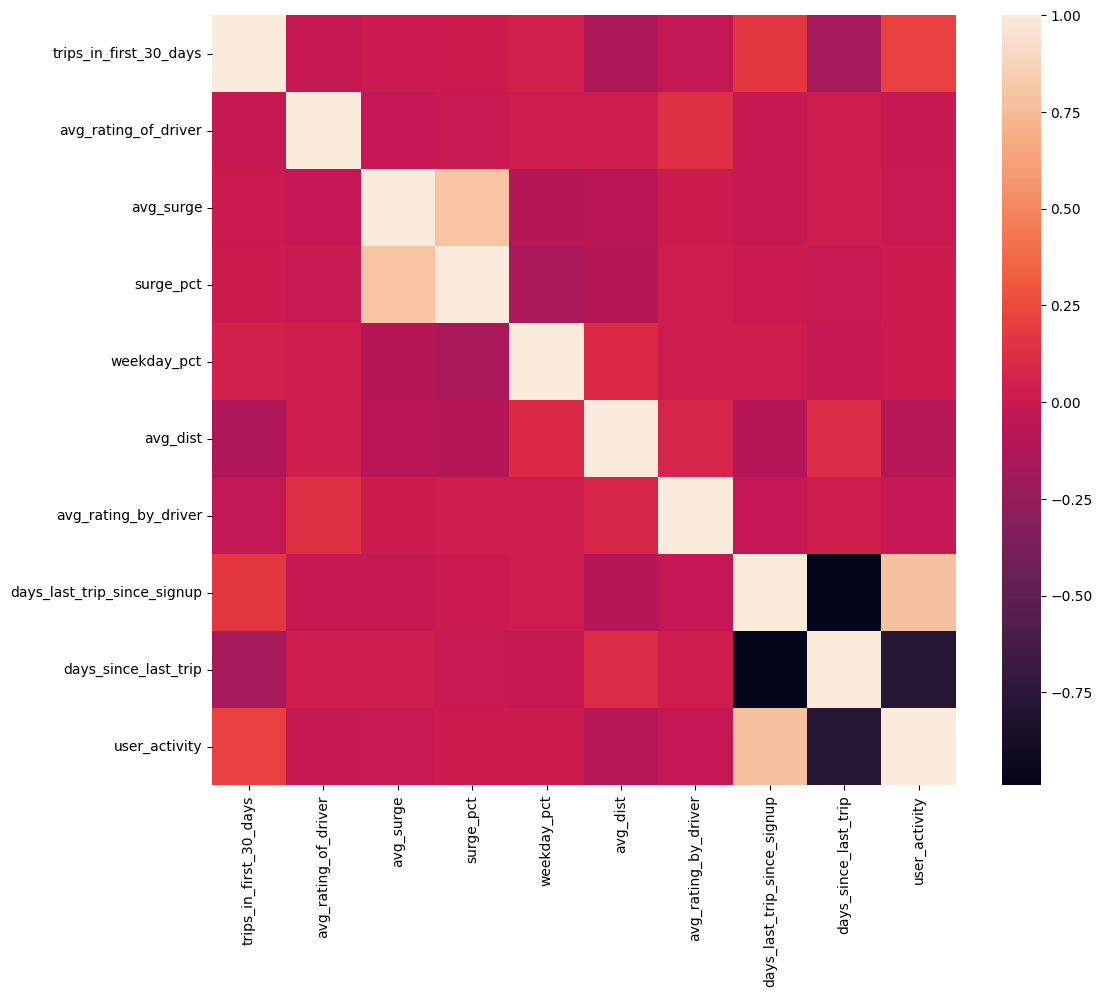

In [131]:
df_numerical=df[['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct','avg_dist', 'avg_rating_by_driver',  'days_last_trip_since_signup','days_since_last_trip','user_activity']]
plt.subplots(figsize=(12,10))
sns.heatmap(df_numerical.corr());

In [19]:
df = df.drop(['days_since_signup','days_since_last_trip','days_last_trip_since_signup'], axis = 1)

## Train/Test Split and Data Preparation

define x and y

In [20]:
y = df['user_activity']
X = df.drop(['user_activity'], axis =1)

Transform categorical variables using one hot encoding, and use imputing strategies to fill in for missing values

In [21]:
numeric_features = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','ultimate_black_user',
                    'weekday_pct','avg_dist','avg_rating_by_driver']

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["city", "phone"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Apply logistic regression model

In [22]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.722


In [23]:
categories_features = list(clf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['city', 'phone']))

Tune the C parameter of the algorithm and do cross validation

In [24]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__C": [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['trips_in_first_30_days',
                                                                          'avg_rating_of_driver',
                                                                          'avg_surge',
                                                                          'surge_pct',
                                                                          'ultimate_black_user',
                                                                          'weekday_pct',
                                                                          'avg_dist',
                                                                          'avg_rating_by_driver']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['city',
                                                                          'phone'])])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1.0, 10, 100],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']})

Fit the model

In [25]:
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Best params:
{'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'median'}


In [26]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "param_preprocessor__num__imputer__strategy",
        "param_classifier__C",
    ]
]

,mean_test_score,std_test_score,param_preprocessor__num__imputer__strategy,param_classifier__C
1,0.717125,0.010226,median,0.1
3,0.717075,0.010324,median,1.0
5,0.717050,0.010339,median,10
7,0.717050,0.010339,median,100
0,0.716175,0.010447,mean,0.1
2,0.716050,0.010512,mean,1.0
4,0.716050,0.010512,mean,10
6,0.716050,0.010512,mean,100


In [27]:
print(
    (
        "best logistic regression from grid search: %.3f"
        % grid_search.score(X_test, y_test)
    )
)

best logistic regression from grid search: 0.722


The metric that we should use to evaluate the model is precision to reduce the number of false positive, or wrong classification of active users. 

              precision    recall  f1-score   support

           0       0.74      0.86      0.79      6251
           1       0.68      0.50      0.57      3749

    accuracy                           0.72     10000
   macro avg       0.71      0.68      0.68     10000
weighted avg       0.72      0.72      0.71     10000



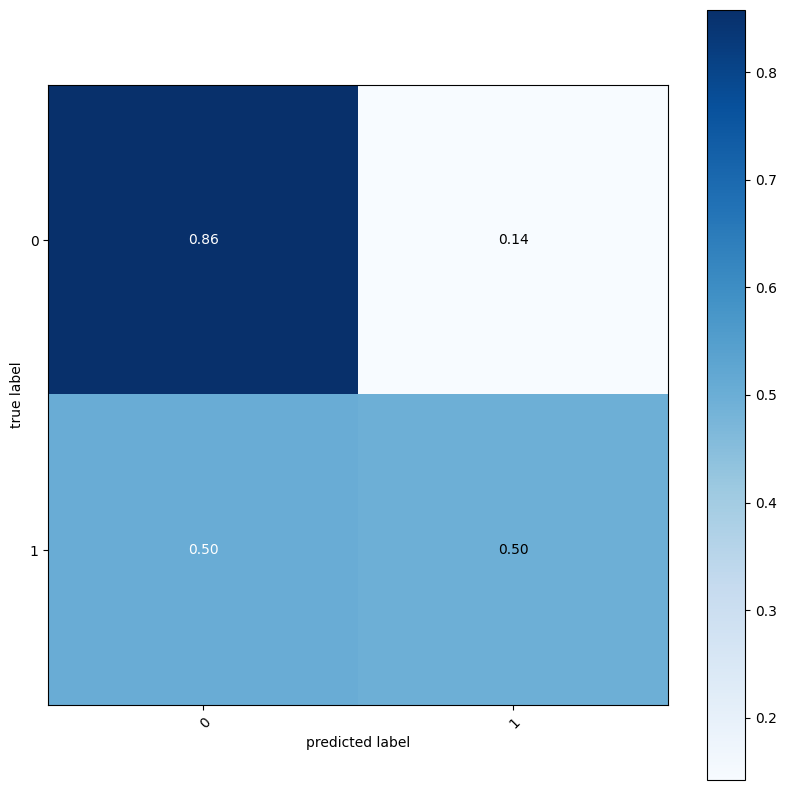

In [28]:
predicted_LR = grid_search.predict(X_test)
print(classification_report(y_test, predicted_LR))

multiclass = confusion_matrix(y_test, predicted_LR)

class_names = grid_search.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

false active, false positive, do something engaging with them, optimize precision

In [54]:
numeric_features = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','ultimate_black_user',
                    'weekday_pct','avg_dist']

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

categorical_features = ["city", "phone"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", tree.DecisionTreeClassifier(criterion="entropy",max_depth = 3, random_state=1234))]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.739


In [55]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__criterion": ["entropy", "gini"],
    "classifier__max_depth": [None, 3]
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['trips_in_first_30_days',
                                                                          'avg_rating_of_driver',
                                                                          'avg_surge',
                                                                          'surge_pct',
                                                                          'ultimate_black_user',
                                                                          'weekday_pct',
                                                                          'avg_dist']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['city',
                                                                          'phone'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               max_depth=3,
                                                               random_state=1234))]),
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__max_depth': [None, 3],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']})

In [56]:
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Best params:
{'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'preprocessor__num__imputer__strategy': 'mean'}


In [57]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "param_preprocessor__num__imputer__strategy",
        "param_classifier__criterion",
        "param_classifier__max_depth"
    ]
]

,mean_test_score,std_test_score,param_preprocessor__num__imputer__strategy,param_classifier__criterion,param_classifier__max_depth
2,0.734125,0.005556,mean,entropy,3
3,0.734125,0.005556,median,entropy,3
6,0.733300,0.005395,mean,gini,3
7,0.733300,0.005395,median,gini,3
4,0.703525,0.007253,mean,gini,None
0,0.702575,0.011138,mean,entropy,None
5,0.702025,0.009862,median,gini,None
1,0.701100,0.008057,median,entropy,None


In [58]:
print(
    (
        "best logistic regression from grid search: %.3f"
        % grid_search.score(X_test, y_test)
    )
)

best logistic regression from grid search: 0.739


              precision    recall  f1-score   support

           0       0.75      0.86      0.81      6251
           1       0.70      0.53      0.60      3749

    accuracy                           0.74     10000
   macro avg       0.73      0.70      0.70     10000
weighted avg       0.73      0.74      0.73     10000



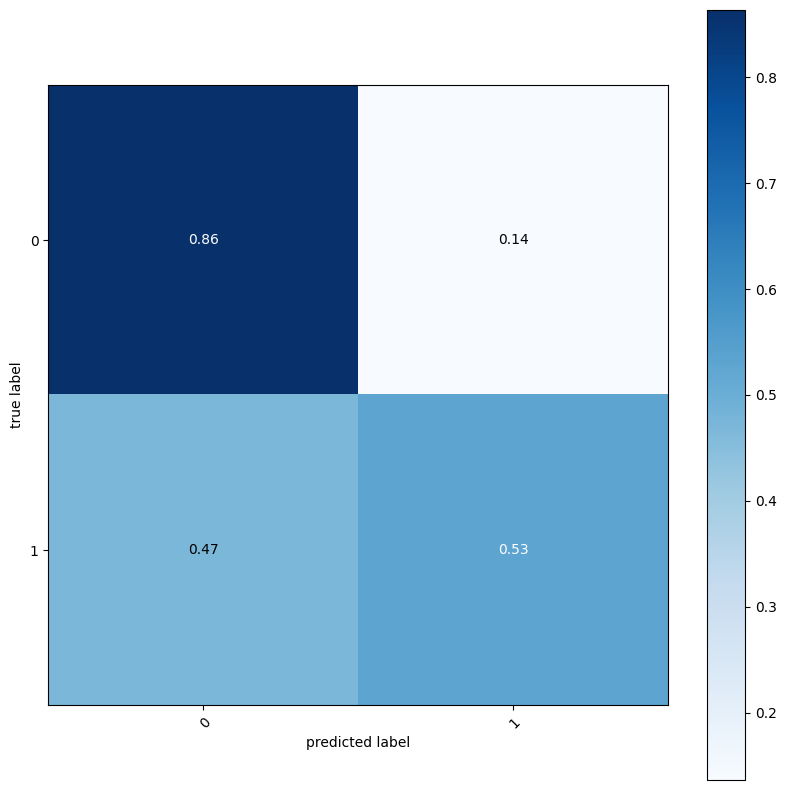

In [59]:
predicted_DT = grid_search.predict(X_test)
print(classification_report(y_test, predicted_DT))

multiclass = confusion_matrix(y_test, predicted_DT)

class_names = grid_search.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

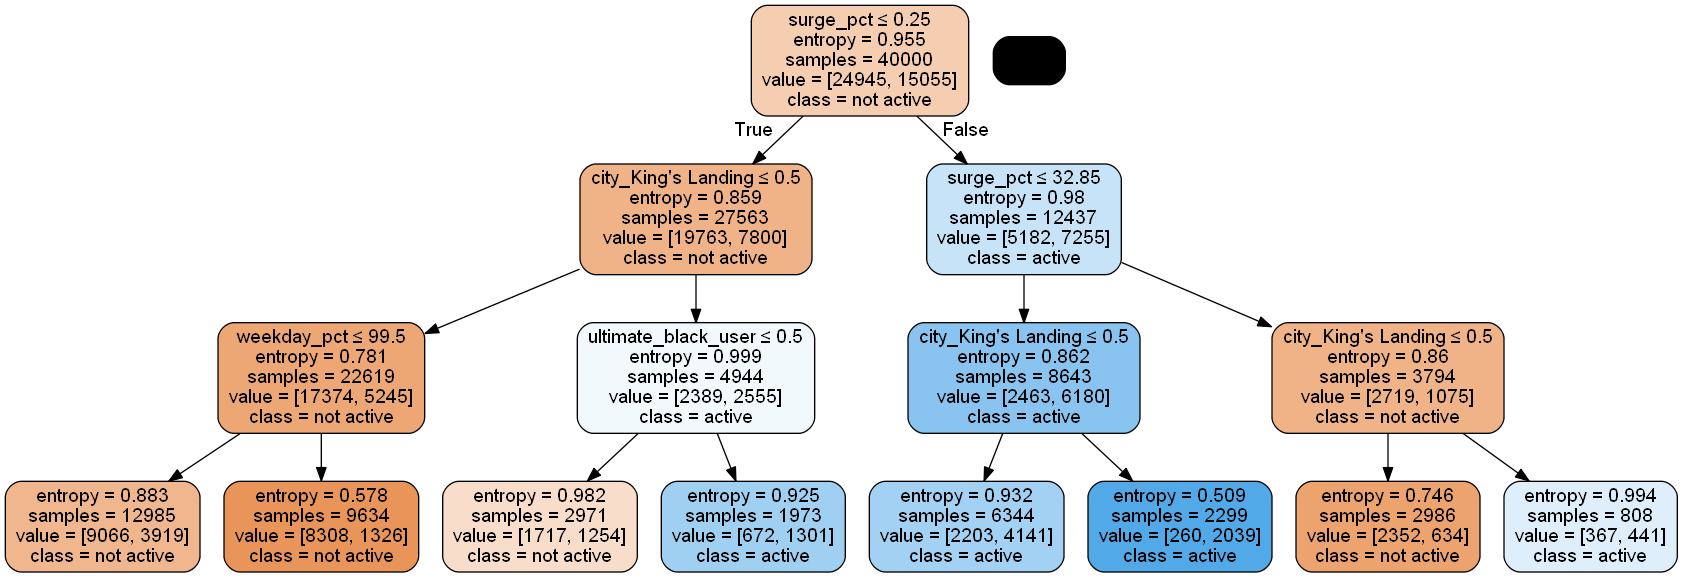

In [69]:
# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(grid_search.best_estimator_.named_steps.classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_names, class_names = ["not active", "active"]) 

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [62]:
feature_names = list(X_train.columns) + categories_features

In [63]:
feature_names

['city',
 'trips_in_first_30_days',
 'avg_rating_of_driver',
 'avg_surge',
 'phone',
 'surge_pct',
 'ultimate_black_user',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver',
 'city_Astapor',
 "city_King's Landing",
 'city_Winterfell',
 'phone_Android',
 'phone_iPhone',
 'phone_None']

In [64]:
feature_names.remove('city')
feature_names.remove('phone')
feature_names.remove('avg_rating_by_driver')

In [309]:
feature_names.remove('phone')

In [61]:
grid_search.best_estimator_.named_steps.classifier.feature_importances_

array([0.        , 0.        , 0.        , 0.60325367, 0.03091822,
       0.09982903, 0.        , 0.        , 0.26599908, 0.        ,
       0.        , 0.        , 0.        ])

According to the decision tree, we find that the most important features for predicting rider retention are the percent of trips taken with surge multiplier > 1 and whether the rider is from King's Landing. Perhaps Ultimate should focus on its users that sign up in King's Landing because they may tend to be more active. Those with a percentage of trips of less than 32% with surge multiplier may indicate that these are more loyal users that despite the surge multiplier, still need to use the Ultimate rides. 